<a href="https://colab.research.google.com/github/kumarmohit0911/des-screening-using-ensemble-technique/blob/main/SWEK1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rdkit torch torchvision torchaudio torch-geometric  pandas scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.7 MB/s eta 0:00:00


In [5]:

# ensemble_with_gin_lightgbm_stacking_fixed.py
# Requirements:
# pip install rdkit-pypi torch torchvision torchaudio torch-geometric xgboost lightgbm scikit-learn pandas joblib

import os
import random
import joblib
import numpy as np
import pandas as pd
from rdkit import Chem
from concurrent.futures import ThreadPoolExecutor, as_completed

import torch
import torch.nn as nn
import torch.nn.functional as F

# PyG imports
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINConv, global_mean_pool

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
import lightgbm as lgb


# CONFIG / SEED

CSV_PATH = "/content/renamed_API_FINAL.csv"   # <-- set path
SMILES_COL = "smiles"
TARGET_COL = "form_DES"
DESCRIPTOR_COLS = [
    'slogp_vsa1', 'esol', 'nhbdon', 'tpsa', 'chi1n', 'zagreb2', 'zagreb1',
    'chi2n', 'chi1v', 'randic', 'chi2v', 'chi0n', 'chi3n',
    'numberofrotablebond', 'chi3v', 'nhbacc', 'chi4n', 'chi0v', 'chi4v',
    'atomicnumber', 'bondcount', 'molecularweight'
]


NUM_THREADS = 8
BATCH_SIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

print("Device:", DEVICE)


# 1) load csv & validate smiles (parallel)

df = pd.read_csv(CSV_PATH)
print("Loaded rows:", len(df))

def valid_smiles(smi):
    try:
        return Chem.MolFromSmiles(smi) is not None
    except Exception:
        return False

with ThreadPoolExecutor(max_workers=NUM_THREADS) as ex:
    valid_flags = list(ex.map(valid_smiles, df[SMILES_COL].tolist()))

df_valid = df[valid_flags].reset_index(drop=True)
print(f"Valid molecules: {len(df_valid)} / {len(df)}")
if len(df_valid) == 0:
    raise RuntimeError("No valid SMILES found.")


# 2) normalize descriptors (use scaler)

scaler = StandardScaler()
desc_mat = df_valid[DESCRIPTOR_COLS].values.astype(float)
desc_scaled = scaler.fit_transform(desc_mat)
# replace scaled in dataframe copy that we will use when building records
for i, col in enumerate(DESCRIPTOR_COLS):
    df_valid[col] = desc_scaled[:, i]


# 3) atom features helper (10 dims)

def atom_features(atom):
    return [
        float(atom.GetAtomicNum()),
        float(atom.GetTotalDegree()),
        float(atom.GetFormalCharge()),
        float(atom.GetTotalNumHs()),
        float(atom.GetIsAromatic()),
        float(atom.GetMass()),
        float(int(atom.GetHybridization())),
        float(atom.GetImplicitValence()),
        float(atom.GetExplicitValence()),
        float(int(atom.GetChiralTag()))
    ]


# 4) SMILES -> PyG Data (parallel)

def mol_to_graph_tuple(record):
    smiles, y, desc = record
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        x = torch.tensor([atom_features(a) for a in mol.GetAtoms()], dtype=torch.float)
        edge_index = []
        edge_attr = []
        for b in mol.GetBonds():
            i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
            edge_index.extend([[i,j],[j,i]])
            bt = b.GetBondType()
            val = {
                Chem.BondType.SINGLE: 1.0,
                Chem.BondType.DOUBLE: 2.0,
                Chem.BondType.TRIPLE: 3.0,
                Chem.BondType.AROMATIC: 4.0
            }.get(bt, 0.0)
            edge_attr.extend([[val],[val]])
        # drop single-atom molecules (no bonds) to avoid edge-less graphs in this simple pipeline
        if len(edge_index) == 0:
            return None
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
        data = Data(
            x=x,
            edge_index=edge_index,
            edge_attr=edge_attr,
            y=torch.tensor([float(y)], dtype=torch.float),
            desc=torch.tensor(desc, dtype=torch.float).unsqueeze(0)  # [1, desc_dim]
        )
        return data
    except Exception:
        return None

records = list(zip(df_valid[SMILES_COL].tolist(),
                   df_valid[TARGET_COL].tolist(),
                   df_valid[DESCRIPTOR_COLS].values.tolist()))

data_list = []
with ThreadPoolExecutor(max_workers=NUM_THREADS) as ex:
    futures = [ex.submit(mol_to_graph_tuple, r) for r in records]
    for f in as_completed(futures):
        res = f.result()
        if res is not None:
            data_list.append(res)

print("Converted to graphs:", len(data_list))
if len(data_list) == 0:
    raise RuntimeError("No graphs after conversion.")

# aligned descriptor matrix & labels (respecting data_list order)
desc_array = np.vstack([d.desc.squeeze(0).numpy() for d in data_list])
y_array = np.array([int(d.y.item()) for d in data_list])


# 5) create stratified splits (indices)

all_idx = np.arange(len(data_list))
idx_train_val, idx_test = train_test_split(all_idx, test_size=0.10, random_state=SEED, stratify=y_array)
idx_train, idx_val = train_test_split(idx_train_val, test_size=0.10, random_state=SEED, stratify=y_array[idx_train_val])

print("Split sizes -> train:", len(idx_train), "val:", len(idx_val), "test:", len(idx_test))

train_data = [data_list[i] for i in idx_train]
val_data   = [data_list[i] for i in idx_val]
test_data  = [data_list[i] for i in idx_test]

def batch_desc(batch_list):
    batch = Batch.from_data_list(batch_list)
    batch.desc = torch.cat([d.desc for d in batch_list], dim=0)
    return batch

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=batch_desc)
val_loader   = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=batch_desc)
test_loader  = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=batch_desc)

# arrays for descriptor models
X_train = desc_array[idx_train]; y_train = y_array[idx_train]
X_val   = desc_array[idx_val];   y_val   = y_array[idx_val]
X_test  = desc_array[idx_test];  y_test  = y_array[idx_test]


# 6) GIN-based GNN (descriptor fusion)

class GIN_GNN(nn.Module):
    def __init__(self, num_node_features, desc_dim, hidden_dim=64, dropout=0.4):
        super().__init__()
        nn1 = nn.Sequential(nn.Linear(num_node_features, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
        nn2 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
        self.conv1 = GINConv(nn1)
        self.conv2 = GINConv(nn2)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

        self.fc_gnn = nn.Linear(hidden_dim, 64)
        self.fc_desc = nn.Linear(desc_dim, 64)
        self.fc_combined = nn.Linear(128, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        desc = data.desc.to(x.device)
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.relu(self.bn2(self.conv2(x, edge_index))) + x
        x_pool = global_mean_pool(x, batch)
        x_gnn = self.dropout(F.relu(self.fc_gnn(x_pool)))
        x_desc = self.dropout(F.relu(self.fc_desc(desc)))
        combined = torch.cat([x_gnn, x_desc], dim=1)
        out = torch.sigmoid(self.fc_combined(combined))
        return out.view(-1)

desc_dim = desc_array.shape[1]
gnn_model = GIN_GNN(num_node_features=10, desc_dim=desc_dim, hidden_dim=64, dropout=0.4).to(DEVICE)


# 7) Train GNN (no early stopping; scheduler ReduceLROnPlateau used)

unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))
pos_weight = (len(y_train) - class_counts.get(1,0)) / (class_counts.get(1,0) + 1e-8)
print("Class counts(train):", class_counts, "pos_weight:", pos_weight)

optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=8e-4, weight_decay=5e-4)
scheduler_gnn = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_gnn, mode='max', factor=0.5, patience=10)
EPOCHS_GNN = 120

print("Start GNN training...")
for epoch in range(1, EPOCHS_GNN+1):
    gnn_model.train()
    preds_tr, ys_tr, losses = [], [], []
    for batch in train_loader:
        batch = batch.to(DEVICE)
        optimizer_gnn.zero_grad()
        out = gnn_model(batch)
        sample_weights = torch.where(batch.y.view(-1)==1,
                                     torch.tensor(pos_weight, device=DEVICE, dtype=torch.float),
                                     torch.tensor(1.0, device=DEVICE, dtype=torch.float))
        loss = F.binary_cross_entropy(out, batch.y.view(-1), weight=sample_weights)
        loss.backward()
        optimizer_gnn.step()
        preds_tr.extend(out.detach().cpu().numpy())
        ys_tr.extend(batch.y.cpu().numpy())
        losses.append(loss.item())

    train_acc = ((np.array(preds_tr)>0.5).astype(int) == np.array(ys_tr)).mean()

    # validation
    gnn_model.eval()
    preds_val, ys_val = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(DEVICE)
            out = gnn_model(batch)
            preds_val.extend(out.cpu().numpy())
            ys_val.extend(batch.y.cpu().numpy())
    val_acc = ((np.array(preds_val)>0.5).astype(int) == np.array(ys_val)).mean()

    scheduler_gnn.step(val_acc)
    if epoch % 10 == 0 or epoch==1 or epoch==EPOCHS_GNN:
        print(f"Epoch {epoch:03d} | Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f} | Loss: {np.mean(losses):.4f}")

# save GNN
# torch.save(gnn_model.state_dict(), "gnn_gin_model.pt")
# print("Saved GIN GNN -> gnn_gin_model.pt")


# 8) ANN on descriptors (train & keep best by val acc)

class ANN_Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, dropout=0.4):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        return torch.sigmoid(self.fc3(x)).view(-1)

ann_model = ANN_Classifier(input_dim=desc_dim, hidden_dim=128, dropout=0.4).to(DEVICE)
opt_ann = torch.optim.Adam(ann_model.parameters(), lr=1e-3, weight_decay=5e-5)
scheduler_ann = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_ann, mode='max', factor=0.5, patience=10)
crit_ann = nn.BCELoss(reduction='none')

EPOCHS_ANN = 120
batch_size = 64
best_ann_state = None
best_ann_val = -1.0

print("Start ANN training...")
for epoch in range(1, EPOCHS_ANN+1):
    ann_model.train()
    perm = np.random.permutation(len(X_train))
    for i in range(0, len(X_train), batch_size):
        idx = perm[i:i+batch_size]
        xb = torch.tensor(X_train[idx], dtype=torch.float).to(DEVICE)
        yb = torch.tensor(y_train[idx], dtype=torch.float).to(DEVICE)
        opt_ann.zero_grad()
        out = ann_model(xb)
        sample_weights = torch.where(yb==1, torch.tensor(pos_weight, device=DEVICE, dtype=torch.float), torch.tensor(1.0, device=DEVICE))
        loss = (crit_ann(out, yb) * sample_weights).mean()
        loss.backward()
        opt_ann.step()

    # val eval
    ann_model.eval()
    with torch.no_grad():
        val_out = ann_model(torch.tensor(X_val, dtype=torch.float).to(DEVICE)).detach().cpu().numpy()
    val_acc = ((val_out>0.5).astype(int) == y_val).mean()
    scheduler_ann.step(val_acc)
    if val_acc > best_ann_val:
        best_ann_val = val_acc
        best_ann_state = ann_model.state_dict()
    if epoch % 20 == 0 or epoch==1:
        print(f"ANN Epoch {epoch:03d} | Val Acc (desc): {val_acc:.3f}")

# restore best ANN
if best_ann_state is not None:
    ann_model.load_state_dict(best_ann_state)
# torch.save(ann_model.state_dict(), "ann_model.pt")
# print("Saved ANN -> ann_model.pt")


# 9) XGBoost & LightGBM on descriptors (fit using train, validate with val)

print("Training XGBoost and LightGBM...")
xgb_model = xgb.XGBClassifier(n_estimators=300, max_depth=5, learning_rate=0.08, use_label_encoder=False, eval_metric='logloss', random_state=SEED)
try:
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
except TypeError:
    # fallback if early_stopping_rounds not accepted by your xgboost build
    xgb_model.fit(X_train, y_train)

lgb_model = lgb.LGBMClassifier(n_estimators=500, num_leaves=31, learning_rate=0.05, random_state=SEED)
lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='binary_logloss')

# joblib.dump(xgb_model, "xgb_model.joblib")
# joblib.dump(lgb_model, "lgb_model.joblib")
# print("Saved XGB & LGB models")


# 10) Collect predictions on VAL for stacking

# GNN val probs (ordered)
val_loader_for_preds = DataLoader([data_list[i] for i in idx_val], batch_size=BATCH_SIZE, shuffle=False, collate_fn=batch_desc)
gnn_model.eval()
gnn_val_probs = []
with torch.no_grad():
    for batch in val_loader_for_preds:
        batch = batch.to(DEVICE)
        out = gnn_model(batch)
        gnn_val_probs.extend(out.detach().cpu().numpy())
gnn_val_probs = np.array(gnn_val_probs).reshape(-1)

# ANN val probs
ann_model.eval()
with torch.no_grad():
    ann_val_probs = ann_model(torch.tensor(X_val, dtype=torch.float).to(DEVICE)).detach().cpu().numpy().reshape(-1)

# XGB & LGB val probs
xgb_val_probs = xgb_model.predict_proba(X_val)[:,1].reshape(-1)
lgb_val_probs = lgb_model.predict_proba(X_val)[:,1].reshape(-1)

# stacking features on val
stack_val_X = np.vstack([gnn_val_probs, ann_val_probs, xgb_val_probs, lgb_val_probs]).T
stack_val_y = y_val


# 11) Train meta-learner (Logistic Regression) on VAL

meta = LogisticRegression(max_iter=2000, solver='lbfgs')
meta.fit(stack_val_X, stack_val_y)
# joblib.dump(meta, "meta_logreg.joblib")
# print("Saved meta-learner -> meta_logreg.joblib")

# optimize threshold on val to maximize F1
meta_val_probs = meta.predict_proba(stack_val_X)[:,1]
prec, rec, thr = precision_recall_curve(stack_val_y, meta_val_probs)
f1_scores = 2*prec*rec/(prec+rec+1e-12)
best_idx = np.nanargmax(f1_scores)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
print(f"Best threshold on VAL (maximize F1): {best_thr:.4f} | Val F1: {f1_scores[best_idx]:.4f}")


# 12) Evaluate on TEST using stacking & chosen threshold

# GNN test probs
test_loader_for_preds = DataLoader([data_list[i] for i in idx_test], batch_size=BATCH_SIZE, shuffle=False, collate_fn=batch_desc)
gnn_test_probs = []
y_true = []
with torch.no_grad():
    for batch in test_loader_for_preds:
        batch = batch.to(DEVICE)
        out = gnn_model(batch)
        gnn_test_probs.extend(out.detach().cpu().numpy())
        y_true.extend(batch.y.cpu().numpy())
gnn_test_probs = np.array(gnn_test_probs).reshape(-1)
y_true = np.array(y_true).astype(int).reshape(-1)

# ANN test probs
ann_test_probs = ann_model(torch.tensor(X_test, dtype=torch.float).to(DEVICE)).detach().cpu().numpy().reshape(-1)

# XGB & LGB test probs
xgb_test_probs = xgb_model.predict_proba(X_test)[:,1].reshape(-1)
lgb_test_probs = lgb_model.predict_proba(X_test)[:,1].reshape(-1)

# meta prediction
stack_test_X = np.vstack([gnn_test_probs, ann_test_probs, xgb_test_probs, lgb_test_probs]).T
meta_probs = meta.predict_proba(stack_test_X)[:,1]
y_pred = (meta_probs > best_thr).astype(int)

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc = roc_auc_score(y_true, meta_probs)
cm = confusion_matrix(y_true, y_pred)

print("\n📊 FINAL ENSEMBLE (STACKING) PERFORMANCE on TEST:")
print(f"Accuracy : {acc*100:.2f}%")
print(f"F1 Score : {f1:.3f}")
print(f"ROC AUC  : {roc:.3f}")
print("Confusion Matrix:\n", cm)


# 13) BUNDLE EVERYTHING INTO ONE FILE

bundle = {
    "gnn_state_dict": gnn_model.state_dict(),
    "ann_state_dict": ann_model.state_dict(),
    "xgb_model": xgb_model,
    "lgb_model": lgb_model,
    "meta_model": meta,
    "scaler": scaler,
    "best_thr": best_thr,
    "desc_cols": DESCRIPTOR_COLS,
}
joblib.dump(bundle, "final_model_bundle.pkl")
print("\n✅ Saved everything into single file: final_model_bundle.pkl")



Device: cuda
Loaded rows: 1465


[12:39:41] WARNING: not removing hydrogen atom without neighbors
[12:39:41] WARNING: not removing hydrogen atom without neighbors
[12:39:41] SMILES Parse Error: syntax error while parsing: CC(=O)O–[CoQ10
[12:39:41] SMILES Parse Error: check for mistakes around position 8:
[12:39:41] CC(=O)O–[CoQ10
[12:39:41] ~~~~~~~^
[12:39:41] SMILES Parse Error: Failed parsing SMILES 'CC(=O)O–[CoQ10' for input: 'CC(=O)O–[CoQ10'
[12:39:41] WARNING: not removing hydrogen atom without neighbors
[12:39:41] WARNING: not removing hydrogen atom without neighbors
[12:39:41] WARNING: not removing hydrogen atom without neighbors
[12:39:41] WARNING: not removing hydrogen atom without neighbors
[12:39:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[12:39:41] DEPRECATION WARNING: please use GetValence(which=)
[12:39:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[12:39:41] DEPRECATION WARNING: please use GetValence(which=)
[12:39:41] DEPRECATION WARNING: please use GetValence

Valid molecules: 1464 / 1465


Streaming output truncated to the last 5000 lines.
[12:39:43] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[12:39:43] DEPRECATION WARNING: please use GetValence(which=)
[12:39:43] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[12:39:43] DEPRECATION WARNING: please use GetValence(which=)
[12:39:43] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[12:39:43] DEPRECATION WARNING: please use GetValence(which=)
[12:39:43] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[12:39:43] DEPRECATION WARNING: please use GetValence(which=)
[12:39:43] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[12:39:43] DEPRECATION WARNING: please use GetValence(which=)
[12:39:43] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[12:39:43] DEPRECATION WARNING: please use GetValence(which=)
[12:39:43] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[12:39:43] DEPRECATION WARNING: please use GetValence(which=)
[12:

Converted to graphs: 1407
Split sizes -> train: 1139 val: 127 test: 141
Class counts(train): {np.int64(0): np.int64(452), np.int64(1): np.int64(687)} pos_weight: 0.6579330422029412
Start GNN training...
Epoch 001 | Train Acc: 0.690 | Val Acc: 0.724 | Loss: 0.4887
Epoch 010 | Train Acc: 0.816 | Val Acc: 0.858 | Loss: 0.3130
Epoch 020 | Train Acc: 0.859 | Val Acc: 0.803 | Loss: 0.2800
Epoch 030 | Train Acc: 0.881 | Val Acc: 0.843 | Loss: 0.2350
Epoch 040 | Train Acc: 0.891 | Val Acc: 0.717 | Loss: 0.2189
Epoch 050 | Train Acc: 0.888 | Val Acc: 0.772 | Loss: 0.2050
Epoch 060 | Train Acc: 0.907 | Val Acc: 0.835 | Loss: 0.1986
Epoch 070 | Train Acc: 0.917 | Val Acc: 0.866 | Loss: 0.1821
Epoch 080 | Train Acc: 0.895 | Val Acc: 0.882 | Loss: 0.1867
Epoch 090 | Train Acc: 0.908 | Val Acc: 0.866 | Loss: 0.1952
Epoch 100 | Train Acc: 0.917 | Val Acc: 0.874 | Loss: 0.1858
Epoch 110 | Train Acc: 0.917 | Val Acc: 0.882 | Loss: 0.1731
Epoch 120 | Train Acc: 0.907 | Val Acc: 0.866 | Loss: 0.1811
Star

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:40:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[56]	validation_0-logloss:0.30677
[57]	validation_0-logloss:0.30549
[58]	validation_0-logloss:0.30502
[59]	validation_0-logloss:0.30534
[60]	validation_0-logloss:0.30238
[61]	validation_0-logloss:0.30107
[62]	validation_0-logloss:0.30049
[63]	validation_0-logloss:0.29771
[64]	validation_0-logloss:0.29529
[65]	validation_0-logloss:0.29430
[66]	validation_0-logloss:0.29434
[67]	validation_0-logloss:0.29388
[68]	validation_0-logloss:0.29409
[69]	validation_0-logloss:0.29425
[70]	validation_0-logloss:0.29422
[71]	validation_0-logloss:0.29403
[72]	validation_0-logloss:0.29381
[73]	validation_0-logloss:0.29332
[74]	validation_0-logloss:0.29318
[75]	validation_0-logloss:0.29239
[76]	validation_0-logloss:0.29211
[77]	validation_0-logloss:0.29169
[78]	validation_0-logloss:0.29107
[79]	validation_0-logloss:0.28973
[80]	validation_0-logloss:0.28976
[81]	validation_0-logloss:0.28896
[82]	validation_0-logloss:0.28890
[83]	validation_0-logloss:0.29038
[84]	validation_0-logloss:0.29308
[85]	validatio

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Best threshold on VAL (maximize F1): 0.6037 | Val F1: 0.9396

📊 FINAL ENSEMBLE (STACKING) PERFORMANCE on TEST:
Accuracy : 92.20%
F1 Score : 0.933
ROC AUC  : 0.972
Confusion Matrix:
 [[54  2]
 [ 9 76]]

✅ Saved everything into single file: final_model_bundle.pkl


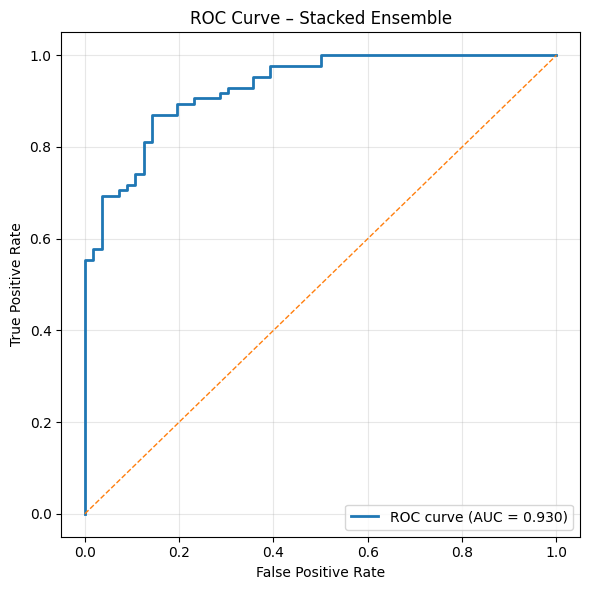

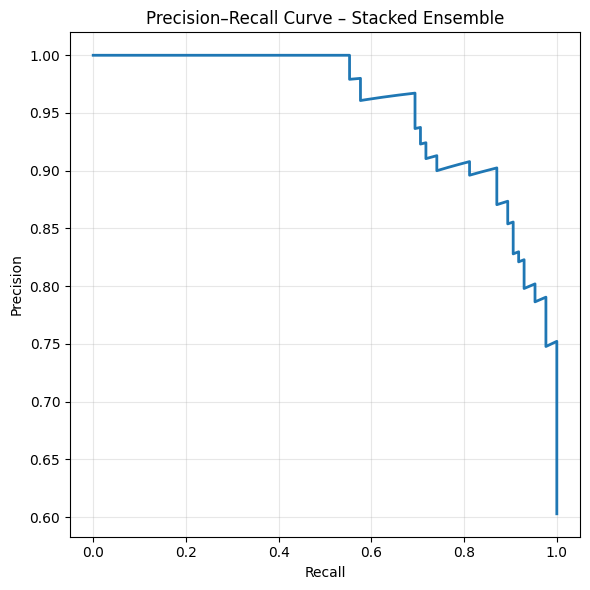

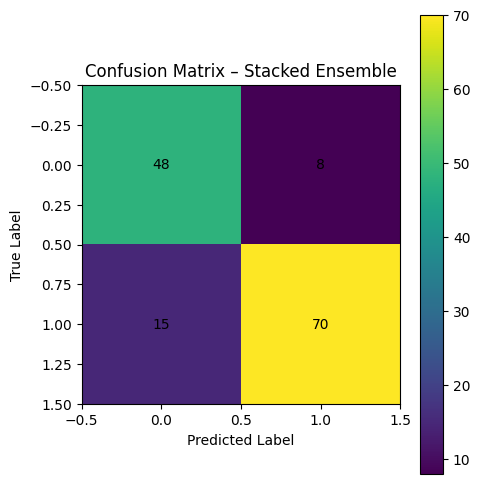

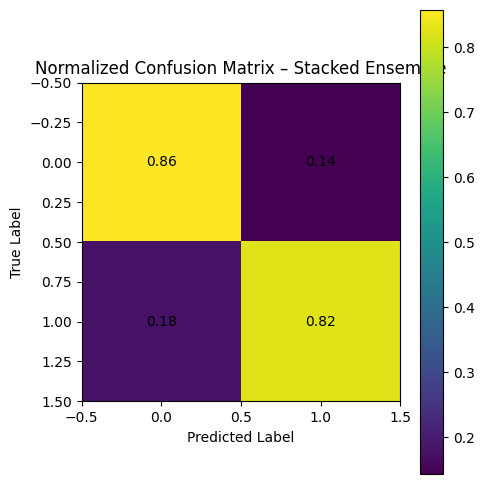

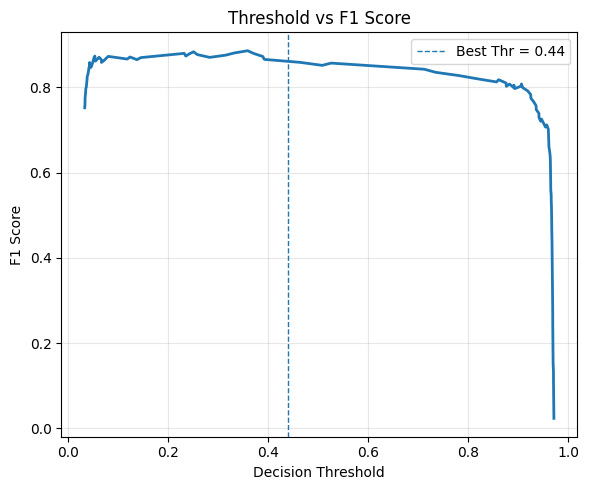

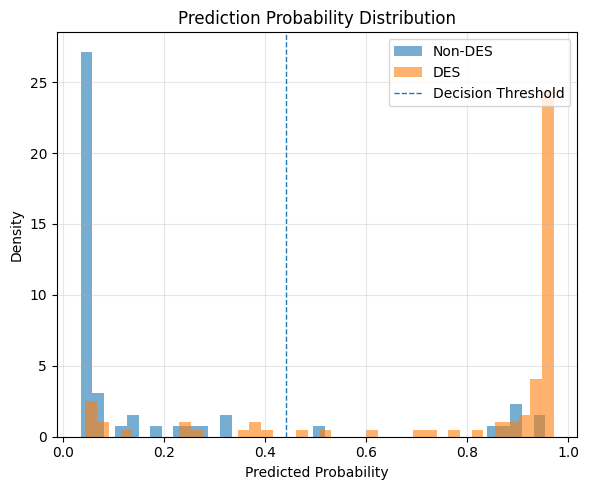

In [4]:

# 14) EVALUATION & PLOTTING (ROC, PR, CM, etc.)


import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve,
    confusion_matrix
)


# 1) ROC Curve

fpr, tpr, roc_thresholds = roc_curve(y_true, meta_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, linewidth=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Stacked Ensemble")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("roc_curve.png", dpi=300)
plt.show()


# 2) Precision–Recall Curve

precision, recall, pr_thresholds = precision_recall_curve(y_true, meta_probs)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Stacked Ensemble")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("precision_recall_curve.png", dpi=300)
plt.show()


# 3) Confusion Matrix (Raw)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
plt.imshow(cm)
plt.title("Confusion Matrix – Stacked Ensemble")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center")

plt.tight_layout()
plt.savefig("confusion_matrix_raw.png", dpi=300)
plt.show()


# 4) Confusion Matrix (Normalized)

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(5,5))
plt.imshow(cm_norm)
plt.title("Normalized Confusion Matrix – Stacked Ensemble")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}",
                 ha="center", va="center")

plt.tight_layout()
plt.savefig("confusion_matrix_normalized.png", dpi=300)
plt.show()


# 5) Threshold vs F1 Score

f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-12)

plt.figure(figsize=(6,5))
plt.plot(pr_thresholds, f1_scores, linewidth=2)
plt.axvline(best_thr, linestyle="--", linewidth=1, label=f"Best Thr = {best_thr:.2f}")
plt.xlabel("Decision Threshold")
plt.ylabel("F1 Score")
plt.title("Threshold vs F1 Score")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("threshold_vs_f1.png", dpi=300)
plt.show()


# 6) Probability Distribution Plot

plt.figure(figsize=(6,5))
plt.hist(meta_probs[y_true == 0], bins=40, alpha=0.6, label="Non-DES", density=True)
plt.hist(meta_probs[y_true == 1], bins=40, alpha=0.6, label="DES", density=True)
plt.axvline(best_thr, linestyle="--", linewidth=1, label="Decision Threshold")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.title("Prediction Probability Distribution")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("probability_distribution.png", dpi=300)
plt.show()